In [1]:
!pip install sentence-transformers
!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE


c:\Users\Admin\.conda\envs\supply_chain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
df = pd.read_csv(r"data\data_trustpilot.csv") 
df.head()


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,...,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,repeat,1,Flashbay,The company rep I worked with made my transact...,company rep worked made transaction smooth qui...,...,2024-10-23 04:17:44,2024-10-22,10,21,Evening,1,Business Day,129,late_review,0
1,5,US,Pat Anderson,1,Verified,one-time,0,Flashbay,I highly recommend using Flashbay. Immediately...,highly recommend using flashbay immediately or...,...,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,2,Business Day,0,quick_review,1
2,5,CZ,Margarita Orlova,1,Verified,one-time,0,Flashbay,I had the pleasure of working with Shelby Gibs...,pleasure working shelby gibson large order nee...,...,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,Business Day,7,late_review,0
3,5,US,Paola Rivas,1,Verified,one-time,0,Flashbay,I had a fantastic experience with Brian Truong...,fantastic experience brian truong attentive tr...,...,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,0,Business Day,0,quick_review,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,repeat,1,Flashbay,My number-one go-to for computer accessories. ...,numberone goto computer accessories rachel sup...,...,2024-10-23 04:09:05,2024-10-22,10,21,Evening,1,Business Day,103,late_review,0


In [4]:
df["rating"].value_counts()

rating
5    31372
1    16152
4     6290
3     6272
2     4324
Name: count, dtype: int64

In [ ]:

# Initialize the pre-trained sentence transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Extract the text data (preprocessed Text) and labels (ratings)
X = df['text_processed'].tolist()
y = df['rating'].tolist()

# Encode the text data into sentence embeddings
X_embeddings = model.encode(X)

# Apply SMOTE to oversample minority classes
smote = SMOTE()
texts, ratings = smote.fit_resample(X_embeddings, y)

# The result of resampling is now in `texts` and `rating`

# new class distribution after resampling
print(pd.Series(rating).value_counts())

rating
4    10000
1    10000
2    10000
5    10000
3    10000
Name: count, dtype: int64


In [9]:
texts = df_balanced['text_processed'].astype(str).tolist()  
ratings = df_balanced['rating'].astype(int).values  


In [ ]:
# Tokenize and Convert Text to Sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

X = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = 60  
X = pad_sequences(X, maxlen=max_length, padding='post')

# Encode ratings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(ratings)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load GloVe Embeddings
embedding_dim = 300
glove_file = "glove.6B.300d.txt"  

embeddings_index = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))  # Freeze GloVe embeddings
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=5, activation='softmax'))  # 5 classes for 5-star ratings

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Validation Accuracy: ", accuracy * 100, "%")

# Save the model
model.save("rnn_glove_rating_SMOTE.keras")


c:\Users\Admin\.conda\envs\supply_chain\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - accuracy: 0.3663 - loss: 1.4262 - val_accuracy: 0.4586 - val_loss: 1.3053
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.4494 - loss: 1.2855 - val_accuracy: 0.5109 - val_loss: 1.1182
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.5078 - loss: 1.1380 - val_accuracy: 0.5414 - val_loss: 1.0415
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.5447 - loss: 1.0557 - val_accuracy: 0.5730 - val_loss: 1.0015
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.5635 - loss: 1.0109 - val_accuracy: 0.5912 - val_loss: 0.9613
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.5874 - loss: 0.9672 - val_accuracy: 0.5974 - val_loss: 0.9425
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.6063 - loss: 0.9197 - val_accuracy: 0.6110 - val_loss: 0.9113
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 60ms/step - accuracy: 0.6235 -

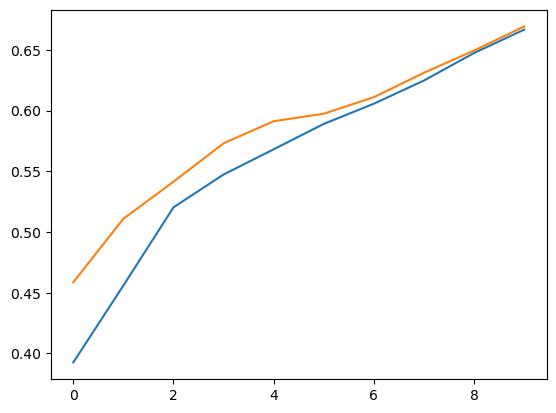

In [11]:
import matplotlib.pyplot as plt
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(train_acc)
plt.plot(val_acc)

In [12]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


In [13]:
import numpy as np
test_pred_class= y_pred.argmax(axis = 1)
y_test_class = y_test

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_class, test_pred_class))
print(confusion_matrix(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.71      0.76      2017
           1       0.58      0.58      0.58      2020
           2       0.55      0.60      0.57      1991
           3       0.65      0.64      0.64      1983
           4       0.80      0.82      0.81      1989

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

[[1439  357  142   58   21]
 [ 226 1167  553   65    9]
 [  65  411 1188  307   20]
 [  24   64  259 1265  371]
 [  39   19   33  265 1633]]
